In [6]:
import torch
import time
import argparse

import numpy as np
import multiprocessing as mp

import sys
sys.path.append('../alphafold_pytorch')

import utils
from alphafold import run_eval, ensemble
from pathlib import Path
from network import ContactsNet
from dataset import ProteinDataLoader
from datetime import datetime

In [2]:
target = "T1019s2" # "T0955" # "casp1" # "T1020" # T1019s2.pkl #caspr9-l64_s0.npy 
prefix = ".npy" #  ".tfrec" # ".pkl"  #
targetFile="T1019s2_in/" + target + prefix
modelDir="model"
outputDir= target + "_out"
timestr = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

In [3]:
print("Saving output to " + outputDir)

Saving output to T1019s2_out


In [4]:
startTime = time.time()

# multi processer
ctx = mp.get_context('spawn')
numParallelProcesser = 0
processes = []

# multi gpus
isEvenlyDistributed = True
isGPU = True

devices = []
if torch.cuda.is_available() and isGPU :
    numDevices = torch.cuda.device_count()
    for deviceIndex in range(0, numDevices):
        devices.append("cuda:" + str(deviceIndex))
else:
    devices = ["cpu"]

target = targetFile.split('/')[-1].split('.')[0]

In [5]:
# running loop
numDevices = len(devices)
count = 0

for replica in range(0, 4):
    mode = ["D","B"]
    if replica == 0 :
        mode = ["D","B", "T"]
        
    for m in mode:
        device = devices[count % numDevices]
        if isEvenlyDistributed:
            count = count + 1
        print("Lauching model: " + m + " " + str(replica) + " on device " + device)
        
        if m == 'D':
            modelType = "Distogram"
            modelPath = Path(modelDir + "/873731")
        elif m == 'B':
            modelType = "Background"
            modelPath = Path(modelDir + "/916425")
        elif m == 'T':
            modelType = "Torsion"
            modelPath = Path(modelDir + "/941521")
            
        outDir = outputDir + "/" + modelType + "/" + str(replica)
        Path(outDir).mkdir(parents=True, exist_ok=True)
        
        print("Input file: " + targetFile)
        print("Output dir: " + outDir)
        print(modelType + " model: " + str(modelPath))
        print("Replica: " + str(replica))
        print("Device: " + str(device))
        # run mode
        # run_eval(targetFile, modelPath, str(replica), Path(outDir), device)
        p = ctx.Process(target=run_eval, args=(targetFile, modelPath, str(replica), Path(outDir), device))
        processes.append(p)
        p.start()
        if len(processes) == numParallelProcesser:
            for p in processes:
                p.join()
            processes = []

if len(processes) > 0:
    for p in processes:
        p.join()
    processes = []

print("All models have been running for %s seconds ---" % (time.time() - startTime))

Lauching model: D 0 on device cuda:0
Input file: T1019s2_in/T1019s2.npy
Output dir: T1019s2_out/Distogram/0
Distogram model: model/873731
Replica: 0
Device: cuda:0
Lauching model: B 0 on device cuda:1
Input file: T1019s2_in/T1019s2.npy
Output dir: T1019s2_out/Background/0
Background model: model/916425
Replica: 0
Device: cuda:1
Lauching model: T 0 on device cuda:0
Input file: T1019s2_in/T1019s2.npy
Output dir: T1019s2_out/Torsion/0
Torsion model: model/941521
Replica: 0
Device: cuda:0
Lauching model: D 1 on device cuda:1
Input file: T1019s2_in/T1019s2.npy
Output dir: T1019s2_out/Distogram/1
Distogram model: model/873731
Replica: 1
Device: cuda:1
Lauching model: B 1 on device cuda:0
Input file: T1019s2_in/T1019s2.npy
Output dir: T1019s2_out/Background/1
Background model: model/916425
Replica: 1
Device: cuda:0
Lauching model: D 2 on device cuda:1
Input file: T1019s2_in/T1019s2.npy
Output dir: T1019s2_out/Distogram/2
Distogram model: model/873731
Replica: 2
Device: cuda:1
Lauching model: 

Ensembling all replica outputs & Pasting contact maps


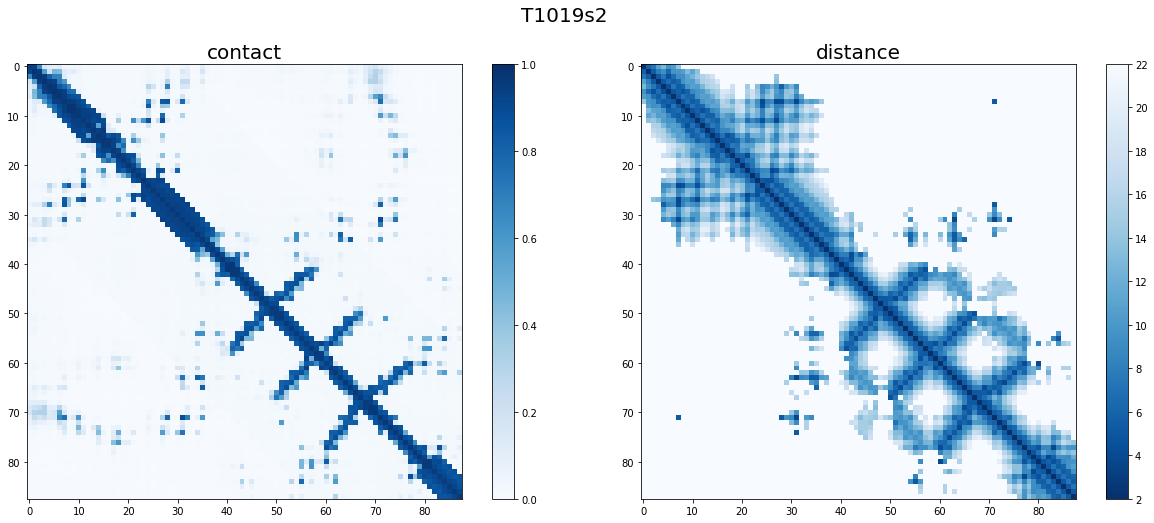

In [6]:
print("Ensembling all replica outputs & Pasting contact maps")
ensemble(targetFile, Path(outputDir))